In [73]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import random
from scipy.optimize import minimize

# Funkcja f(x)

In [74]:
def f(x) -> float:
    return np.sin(x * np.pi) + np.power(x, 2)

In [75]:
def f_grad(x) -> float:
    return np.pi*np.cos(x*np.pi) + 2*x

#### Na początku sprawdzam minimum globalne funkcji `f(x)` za pomocą biblioteki `scipy.optimize` aby porównać wyniki z mojej implementacji

In [76]:
min_f = minimize(f, 0, method='BFGS')
print("Minimum globalne funkcji f(x): ", min_f.x)

Minimum globalne funkcji f(x):  [-0.4149116]


In [77]:
def draw_2D_plot(function, domain, number_of_points) -> None:
    x = np.linspace(domain[0], domain[1], number_of_points)
    y = [function(x_val) for x_val in x]
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(x, y, color='blue', linewidth=2, label='f(x)=sin(xπ)+x^2')
    ax.set_title('2D Plot of f(x)')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.show()

**Obserwacja wykresu funkcji f(x):**

Funkcja `f(x)` jest funkcją jednej zmiennej. Posiada `jedno` globalne minimum położone niedaleko punktu `x = -0.5`. Zoptymalizowanie funkcji algorytmem najszybszego spadku może wymagać dokładnego dobrania punktu początkowego algorytmu oraz dobrego rozmiaru skoku. W przypadku nieodpowiedniego punktu początkowego lub zbyt dużego skoku algorytm może zbiegać do ekstremum lokalnego.

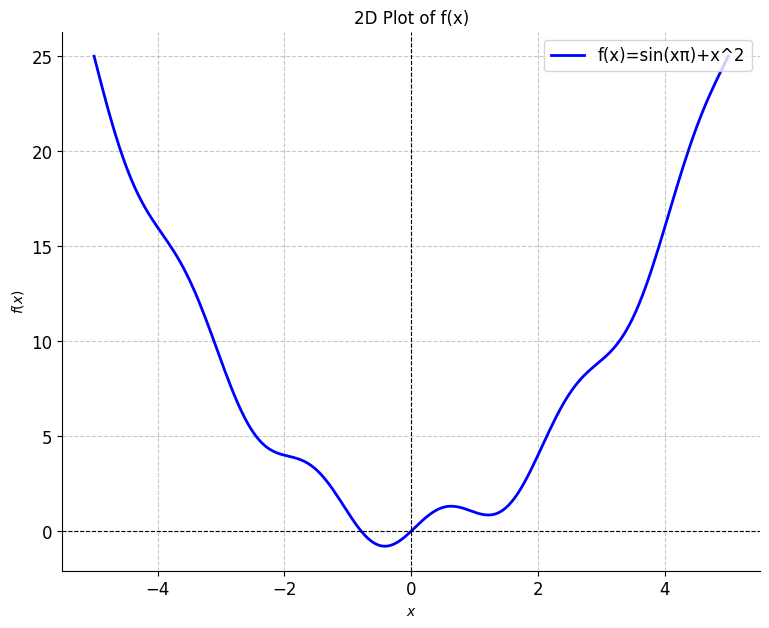

In [78]:
draw_2D_plot(f, (-5, 5), 200)

# Funkcja g(x_i)

In [79]:
def g(x_i) -> float:
    return 5*np.power(np.e, 2) - 4*np.e*x_i[0] + np.power(x_i[0], 2) + 2*np.e*x_i[1] + np.power(x_i[1], 2)

In [80]:
def g_grad(x_i) -> np.array:
    return np.array([-4*np.e + 2*x_i[0], 2*np.e + 2*x_i[1]])

#### Na początku sprawdzam minimum globalne funkcji `g(x_i)` za pomocą biblioteki `scipy.optimize` aby porównać wyniki z mojej implementacji

In [81]:
min_g = minimize(g, [0, 0], method='BFGS')
print("Minimum globalne funkcji g(x_i): ", min_g.x)

Minimum globalne funkcji g(x_i):  [ 5.43656366 -2.7182818 ]


In [82]:
def draw_3D_plot(function, x1_domain, x2_domain, number_of_points) -> None:
    x1 = np.linspace(x1_domain[0], x1_domain[1], number_of_points)
    x2 = np.linspace(x2_domain[0], x2_domain[1], number_of_points)
    x1, x2 = np.meshgrid(x1, x2)
    y = function(np.array([x1, x2]))
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x1, x2, y, cmap='viridis', edgecolor='none', alpha=0.8, antialiased=True, shade=True)
    ax.view_init(40, 20)
    ax.set_xlabel('$x_{0}$')
    ax.set_ylabel('$x_{1}$')
    ax.set_zlabel('$f(x)$')
    cbar = fig.colorbar(ax.plot_surface(x1, x2, y, cmap='viridis'), ax=ax, shrink=0.5, aspect=10)
    plt.title('3D Plot of g(x)')
    ax.grid(True)
    ax.light_sources = 'lightsource'
    plt.show()


**Obserwacja wykresu funkcji g(x_i):**

Funkcja `g(x_i)` jest funkcją dwuwymiarową. `xi` oznacza i-ty element wektora x. Na pierwszy rzut oka funkcja maleje w jednym wyraźnym kierunku. Minimum globalne powinno znaleźć się w okolicy `x1 = 5`, `x2 = -3`. Zoptymalizowanie funkcji algorytmem najszybszego spadku będzie wymagać trudniejszego algorytmu ze względu na większą liczbę wymiarów. Jednak nie powinno być problemu zbiegania do ekstremum lokalnego.

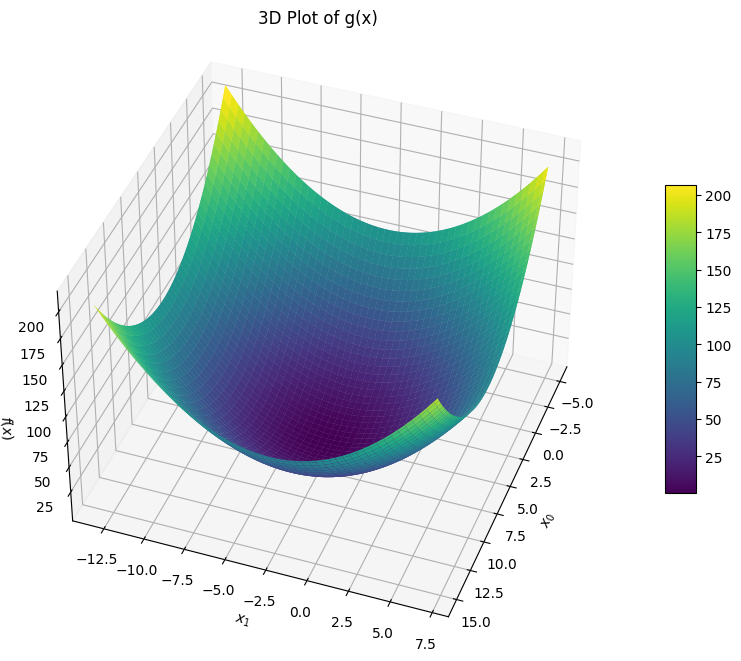

In [83]:
draw_3D_plot(g, (-5, 15), (-13, 7), 100)

# Moja implementacja algorytmu najszybszego spadku

***Funkcja Armijo w algorytmie najmniejszego spadku***

Funkcja `armijo_condition` jest używana do dostosowywania rozmiaru kroku (step size) w algorytmie najmniejszego spadku. W algorytmie tym ważne jest, aby wybierać odpowiedni rozmiar kroku, który pozwoli na efektywne zbliżanie się do minimum funkcji celu. W tej funkcji stosuje się warunek Armijo, który pomaga uniknąć zbyt dużych lub zbyt małych kroków.

- `function`: Funkcja celu, którą minimalizujemy.
- `step`: Aktualny rozmiar kroku, który jest iteracyjnie dostosowywany w tej funkcji.
- `x`: Aktualna pozycja (punkt) w przestrzeni, na której obliczamy wartość funkcji celu.
- `gradient_x`: Gradient funkcji celu w punkcie `x`.
- `c` i `tol`: Stałe kontrolujące warunek Armijo.

***Krok po kroku***

1. Obliczana jest norma kwadratowa (czyli kwadrat normy) wektora gradientu `gradient_x`. To jest to, co robi linijka `np.linalg.norm(gradient_x)**2`. Norma kwadratowa gradientu jest używana, aby ocenić nachylenie funkcji w danym punkcie. Im większa ta wartość, tym bardziej nachylona jest powierzchnia funkcji w danym punkcie.

2. Następnie przechodzimy do pętli `while`. Warunek tej pętli sprawdza, czy warunek Armijo jest spełniony. Warunek Armijo mówi, że nowy punkt, który uzyskujemy przez przesunięcie `x` o pewną wielkość kroku (`step`) w kierunku przeciwnym do gradientu, powinien być na tyle "dobrej jakości", że funkcja celu w tym nowym punkcie nie jest zbyt daleko od wartości funkcji celu w punkcie `x`, wraz z pewnym uwzględnieniem nachylenia (gradientu).

   - `function(x - step * gradient_x)` oblicza wartość funkcji celu w nowym punkcie po wykonaniu kroku.
   - `(function(x) - c * step * gradient_square_norm)` to wartość referencyjna, która jest obliczona na podstawie wartości funkcji celu w punkcie `x` oraz pewnego spadku, który jest proporcjonalny do nachylenia funkcji (mnożone przez stałą `c` i normę kwadratową gradientu).

3. Jeśli warunek Armijo jest spełniony, to oznacza, że krok jest odpowiedni i możemy zwrócić aktualny rozmiar kroku `step`.

4. Jeśli warunek Armijo nie jest spełniony, to zmniejszamy rozmiar kroku `step` o połowę (`step /= 2`) i ponownie sprawdzamy warunek Armijo. To jest iteracyjnie powtarzane aż do momentu, gdy warunek jest spełniony lub `step` stanie się mniejszy niż tolerancja `tol`. Odpowiednie zmniejszanie kroku pomaga uniknąć zbyt dużych kroków, które mogłyby prowadzić do niestabilnych zachowań w algorytmie najmniejszego spadku.

Ta funkcja pomaga kontrolować rozmiar kroku w algorytmie najmniejszego spadku, co jest kluczowe dla jego efektywnego działania.

In [84]:
def armijo_condition(function, step, x, gradient_x) -> float:
    c = 1e-4
    tol = 1e-6
    gradient_square_norm = np.linalg.norm(gradient_x)**2
    while function(x - step * gradient_x) >= (function(x) - c * step * gradient_square_norm):
        step /= 2
        if step < tol:
            break
    return step

**Moja implementacja algorytmu najszybszego spadku:**

Do funkcji przekazuję następujące argumenty:
* `x0` - wektor początkowy od którego rozpoczynamy poszukiwanie minimum (lista floatów)
* `function` - funkcja, której minimum globalne poszukujemy
* `gradient` - gradient funkcji `function`
* `alpha` - rozmiar skoku (float)
* `epsilon` - zmienna decydująca o tym, że funkcja znalazła minimum (lokalne lub globalne) (float)
* `max_iter` - maksymalna liczba iteracji dozwolona do przeprowadzenia (int)
* `armijo` - zmienna decydująca czy używamy warunku armijo czy nie (bool)

Funckja zaczyna iterować i na podstawie wektora `x`, `alpha` oraz `gradientu` wyznacza kolejny wektor `x_next`. Gdy użytkownik zechce może aktywować dostosowywanie rozmiaru skoku `alpha` za pomocą warunku armijo. Następnie zostają obliczone różnice w wartościach funkcji oraz gradientach funkcji dla wektora `x` oraz wektora `x_next`. Jeśli różnica w wartościach funkcji oraz gradientu jest mniejsza od `epsilon` to oznacza, że zostało znalezione ekstremum. Jeśli liczba iteracji przekroczy `max_iter` to oznacza, że nie udało się znaleźć ekstremum. 

Funkcja zwraca krotkę z informacją o wektorze `x` w którym zostało znalezione ekstremum lub None oraz liczbę iteracji wykonanych podczas obliczeń.

In [85]:
def gradient_descent(x0, function, function_grad, alpha, epsilon, max_iter, is_armijo) -> tuple:
    x = np.array(x0)
    for i in range(max_iter):
        if is_armijo:
            alpha = armijo_condition(function, alpha, x, function_grad(x))
        x_next = x - alpha * function_grad(x)
        func_diff = abs(function(x_next) - function(x))
        grad_diff = abs(function_grad(x))
        if (func_diff < epsilon).all() and (grad_diff < epsilon).all():
            return (x, i)
        x = x_next
    return (None, max_iter)

# Badanie wpływu rozmiaru skoku na działanie algorytmu

**Funckje do analizy danych**

Ponieżej znajduje się kilka funkcji "roboczych" do analizy danych. Funkcje te pozwalają na wyświetlenie wykresów oraz tabeli z wynikami.

1. `check_parameters_performance()`:
    dostaje parametry do wykonania algorytmu najszybszego spadku i zwraca wynik działania w postaci kilku informacji zawartych w krotce:
    - `is_global_min` zwraca informację true/false czy udało się znaleźć globalne minimum
    - `iterations` zwraca liczbę iteracji algorytmu najszybszego spadku
    - `global_min_accuracy` zwraca dokładność z jaką udało się znaleźć globalne minimum
    - `result_x` zwraca znalezione x

In [86]:
def check_parameters_performance(func, grad, x0, alpha, epsilon, max_iter, known_glob_min, is_armijo) -> None:
    result_x, iterations = gradient_descent(x0, func, grad, alpha, epsilon, max_iter, is_armijo)
    is_global_min = np.allclose(result_x, known_glob_min, atol=0.1) if result_x is not None else False
    global_min_accuracy = np.abs(result_x - known_glob_min) if result_x is not None else None
    return (is_global_min, iterations, global_min_accuracy, result_x)

2. `custom_sort_key()`:
    Jest potrzebny do sortowania kolumny w dataframe pandas gdy ta jest listą o dwóch wartościach (funkcja wektorowa)

In [87]:
def custom_sort_key(val):
        return val.sum() if isinstance(val, np.ndarray) else val

3. `create_raw_dataframe()`:
    Produkuje plik tekstowy zawierający pandas dataframe z wynikami działania algorytmu najszybszego spadku dla różnych wartości skoku alpha oraz punktów początkowych. W pliku tym znajdują się następujące kolumny:
    - `x0` - punkt początkowy
    - `alpha` - rozmiar skoku
    - `armijo` - czy używamy warunku armijo
    - `is_global_min_found` - czy udało się znaleźć globalne minimum
    - `num_of_iterations` - liczba iteracji algorytmu najszybszego spadku
    - `global_min_accuracy` - dokładność z jaką udało się znaleźć globalne minimum
    - `result_value` - znalezione x
    - `known_function_min` - znane minimum funkcji
    
    Dataframe jest sortowany i zapisywany do pliku tekstowego o nazwie `raw_dataframe_{nazwa_funkcji}.txt`
    Funkcja zwraca wynikowy pd.DataFrame
    

In [88]:
def create_raw_dataframe(function, function_grad, global_min, function_name, dimensions, samples):
    if dimensions == 1:
        x_points = [random.uniform(-15, 15) for _ in range(samples)]
    else:
        x_points = [[random.uniform(-15, 15) for _ in range(dimensions)] for _ in range(samples)]
    alpha_values = [random.uniform(0.01, 1.1) for _ in range(samples)]

    results = []

    for x0 in x_points:
        for alpha in alpha_values:
            for armijo in [False, True]:
                outcome = check_parameters_performance(function, function_grad, np.array(x0), alpha, 0.001, 1000, global_min, armijo)
                is_global_min_found = outcome[0]
                is_other_min_found = not is_global_min_found and outcome[1] < 1000
                out_of_iterations = outcome[1] >= 1000
                global_min_accuracy = outcome[2] if is_global_min_found else None

                results.append({
                    'x0': x0,
                    'alpha': alpha,
                    'armijo': armijo,
                    'is_global_min_found': is_global_min_found,
                    'is_other_min_found': is_other_min_found,
                    'out_of_iterations': out_of_iterations,
                    'number_of_iterations': outcome[1],
                    'global_min_accuracy': global_min_accuracy,
                    'found_value': outcome[3],
                    'known_function_min': global_min
                })

    dataframe = pd.DataFrame(results)
    dataframe['Sort_Key'] = dataframe['global_min_accuracy'].apply(custom_sort_key)
    dataframe.sort_values(by=['is_global_min_found', 'Sort_Key', 'number_of_iterations'],
                                ascending=[False, True, True], inplace=True)
    dataframe.drop(columns=['Sort_Key'], inplace=True)
    dataframe.reset_index(drop=True, inplace=True)

    display_dataframe = dataframe.copy()
    display_dataframe.drop(columns=['is_other_min_found', 'out_of_iterations'], inplace=True)
    with open(f'raw_data_{function_name}.txt', 'w') as file_handler:
        file_handler.write(display_dataframe.to_string())

    return dataframe

4. `create_performance_dataframe()`:
    Tworzy dataframe z podsumowaniem jak dana wartość alpha "poradziła sobie" w algorytmie najszybszego spadku. Dla każdego alhpa liczone są następujące wartości:
    - `Global_min_finds (%)` - procentowo ile razy udało się znaleźć globalne minimum
    - `Other min finds (%)` - procentowo ile razy udało się znaleźć inne minimum niż globalne
    - `Out of iterations (%)` - procentowo ile razy algorytm nie znalazł minimum w maksymalnej liczbie iteracji
    - `Average iterations` - średnia liczba iteracji algorytmu najszybszego spadku
    - `Average global min accuracy` - średnia dokładność z jaką udało się znaleźć globalne minimum

    Następnie rozmiary skoków są sortowane "od najlepszych do najgorszych" i zapisywane do pliku tekstowego o nazwie `performance_dataframe_{nazwa_funkcji}.txt`. Funkcja zwraca wynikowy pd.DataFrame


In [89]:
def create_performance_dataframe(dataframe : pd.DataFrame, function_name : str):
    final_dataframe = dataframe.groupby(['alpha', 'armijo']).agg({
        'is_global_min_found': 'mean',
        'is_other_min_found': 'mean',
        'out_of_iterations': 'mean',
        'number_of_iterations': 'mean',
        'global_min_accuracy': 'mean'
    }).reset_index()

    final_dataframe.rename(columns={'is_global_min_found': 'Global_min_finds (%)'}, inplace=True)
    final_dataframe.rename(columns={'is_other_min_found': 'Other_min_finds (%)'}, inplace=True)
    final_dataframe.rename(columns={'out_of_iterations': 'Out_of_iterations (%)'}, inplace=True)
    final_dataframe.rename(columns={'number_of_iterations': 'Average_number_of_iterations'}, inplace=True)
    final_dataframe.rename(columns={'global_min_accuracy': 'Average_global_min_accuracy'}, inplace=True)

    final_dataframe['Global_min_finds (%)'] *= 100
    final_dataframe['Other_min_finds (%)'] *= 100
    final_dataframe['Out_of_iterations (%)'] *= 100
    final_dataframe['Average_number_of_iterations'] = final_dataframe['Average_number_of_iterations'].round()

    final_dataframe['Sort_Key'] = final_dataframe['Average_global_min_accuracy'].apply(custom_sort_key)
    final_dataframe.sort_values(by=['Global_min_finds (%)', 'Sort_Key', 'Average_number_of_iterations'],
                                ascending=[False, True, True], inplace=True)
    final_dataframe.drop(columns=['Sort_Key'], inplace=True)
    final_dataframe.reset_index(drop=True, inplace=True)

    with open(f'alpha_performance_{function_name}.txt', 'w') as file_handler:
        file_handler.write(final_dataframe.to_string())

    return final_dataframe

5. `plot_axes()`:
    Funkcja pomocnicza do rysowania osi wykresu (wydzielona ze względu na czytelność kodu, zasada DRY)

In [90]:
def plot_axes(ax, x, y, title, x_label, y_label, label, armijo):
    y_valid_indexes = np.where(~np.isnan(y))[0]
    x = [x[i] for i in y_valid_indexes]
    y = [y[i] for i in y_valid_indexes]

    ax.scatter(x, y, marker='o', label=label, s=30 if armijo else 70)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    x_range = np.linspace(min(x), max(x), 100)
    ax.plot(x_range, p(x_range))


6. `process_accuracy()`:
    Funkcja pomocnicza do obliczania dokładności z jaką algorytm najszybszego spadku znalazł minimum (wartość może być typu float, np.ndarray lub NaN)

In [91]:
def process_accuracy(accuracy):
    if isinstance(accuracy, np.ndarray):
        return np.sum(accuracy)
    return np.nan if pd.isna(accuracy) else accuracy

7. `draw_perfomance_graph()`:
    Funkcja rysuje wykres zależności dokładności z jaką algorytm najszybszego spadku znalazł minimum od rozmiaru skoku. Funkcja zwraca 3 wykresy:
    - `Global min finds (%)` - jak wartość współczynnika alpha wpływa na procent znalezionych globalnych minimów
    - `Average_number_of_iterations` - jak wartość współczynnika alpha wpływa na średnią liczbę iteracji algorytmu najszybszego spadku
    - `Average_global_min_accuracy` - jak wartość współczynnika alpha wpływa na średnią dokładność z jaką algorytm najszybszego spadku znalazł globalne minimum

    Wykres podzielony jest na część dla wyników algorytmu z użyciem warunku armijo oraz bez użycia warunku armijo.

In [92]:
def draw_perfomance_graph(final_dataframe: pd.DataFrame, function_name: str):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    armijo_labels = [False, True]
    titles = [
        f'Function {function_name} - Global_min_finds(%) performance',
        f'Function {function_name} - Average_number_of_iterations performance',
        f'Function {function_name} - Average_global_min_accuracy performance'
    ]
    x_labels = ['alpha value', 'alpha value', 'alpha value']
    y_labels = [
        'Global_min_finds (in %)',
        'Average_number_of_iterations',
        'Average_global_min_accuracy'
    ]

    for ax_index, label in enumerate(armijo_labels):
        subset = final_dataframe[final_dataframe['armijo'] == label]
        x_1 = subset['alpha'].tolist()
        y_1 = subset['Global_min_finds (%)'].tolist()
        plot_axes(ax1, x_1, y_1, titles[0], x_labels[0], y_labels[0], f'With Armijo condition' if label else 'Without Armijo condition', label)

        x_2 = subset['alpha'].tolist()
        y_2 = subset['Average_number_of_iterations'].tolist()
        plot_axes(ax2, x_2, y_2, titles[1], x_labels[1], y_labels[1], f'With Armijo condition' if label else 'Without Armijo condition', label)

        x_3 = subset['alpha'].tolist()
        y_3 = [process_accuracy(accuracy) for accuracy in subset['Average_global_min_accuracy']]
        plot_axes(ax3, x_3, y_3, titles[2], x_labels[2], y_labels[2], f'With Armijo condition' if label else 'Without Armijo condition', label)

    ax1.legend(loc='upper right', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)
    ax3.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

***Analiza wykresów f(x)***

Funkcja `f(x)` jest funkcją z wieloma lokalnymi ekstremami dlatego jest podatna na `nieprawidłowe działanie` algorytmu najszybszego spadku.

Wnioski z wykresów:
1. Wykres zależności wielkości współczynnika alpha do % znalezionych minimów globalnych:
    - Algorytm o wiele `lepiej` poradził sobie w przypadku `użycia warunku armijo` (znajdował glonalne minimum w okolicach `60-100%` przypadków). Sama `wartość początkowa alpha nie ma dużego znaczenia`, chodź najlepiej radził sobie dla alpha w okolicy wartości `0.8`. 
    
    - W przypadku `braku warunku armijo` algorytm radził sobie `dużo gorzej` (znajdował globalne minimum w okolicy `0-40%` przypadków). `Wartość początkowa alpha ma duże znaczenie`, chodź najlepiej radził sobie dla alpha w okolicy wartości `0.1 >`.


2. Wykres zależności wielkości współczynnik alpha do ilości iteracji algorytmu najszybszego spadku:
    - Tutaj również algorytm poradził sobie `o wiele lepiej` w przypadku `użycia warunku armijo` (średnio `10-20 iteracji`). `Wartość początkowa alpha nie miała znaczenia`.
    - W przypadku `braku warunku armijo` algorytm radził sobie `dużo gorzej`. Dla `małych wartości` alpha ta liczba może również być mała (średnio `10-20 iteracji`), ale dla `większych wartości alpha > 0.2` liczba iteracji rośnie bardzo szybko i wynosi `od kilkuset do tysiąca iteracji`. Przypomnę tylko, że `1000 iteracji` w mojej implementacji to `wartość graniczna` i jeśli algorytm przekracza tą wartość to oznacza, że `minimum nie zostalo wyznaczone`. Stąd wniosek, że `algorytm bez warunku Armijo ma większe prawdopodobieństwo nieznalezienia minimum globalnego`.


3. Wykres zależności wielkości współczynnik alpha do dokładności z jaką algorytm najszybszego spadku znalazł minimum:
    - W tym przypadku `warunek armijo nie ma większego znaczenia`. Algorytm jesli znajduje, to znajduje minimum z `porównywalną dokładnością`. Jednakże, algorytm bez warunku armijo ma tendencję do "wykrzaczania" algorytmu więc dla większych wartości alpha dokładność jest nieskończona (NaN) - algorytm nie wyznaczył minimum więc nie ma sensu mówić o dokładności. Dlatego jest mniej punktów niebieskich od punktów pomarańczowych.

In [93]:
dataframe_f = create_raw_dataframe(f, f_grad, min_f.x[0], "f(x)", 1, 60)
dataframe_f = create_performance_dataframe(dataframe_f, "f(x)")

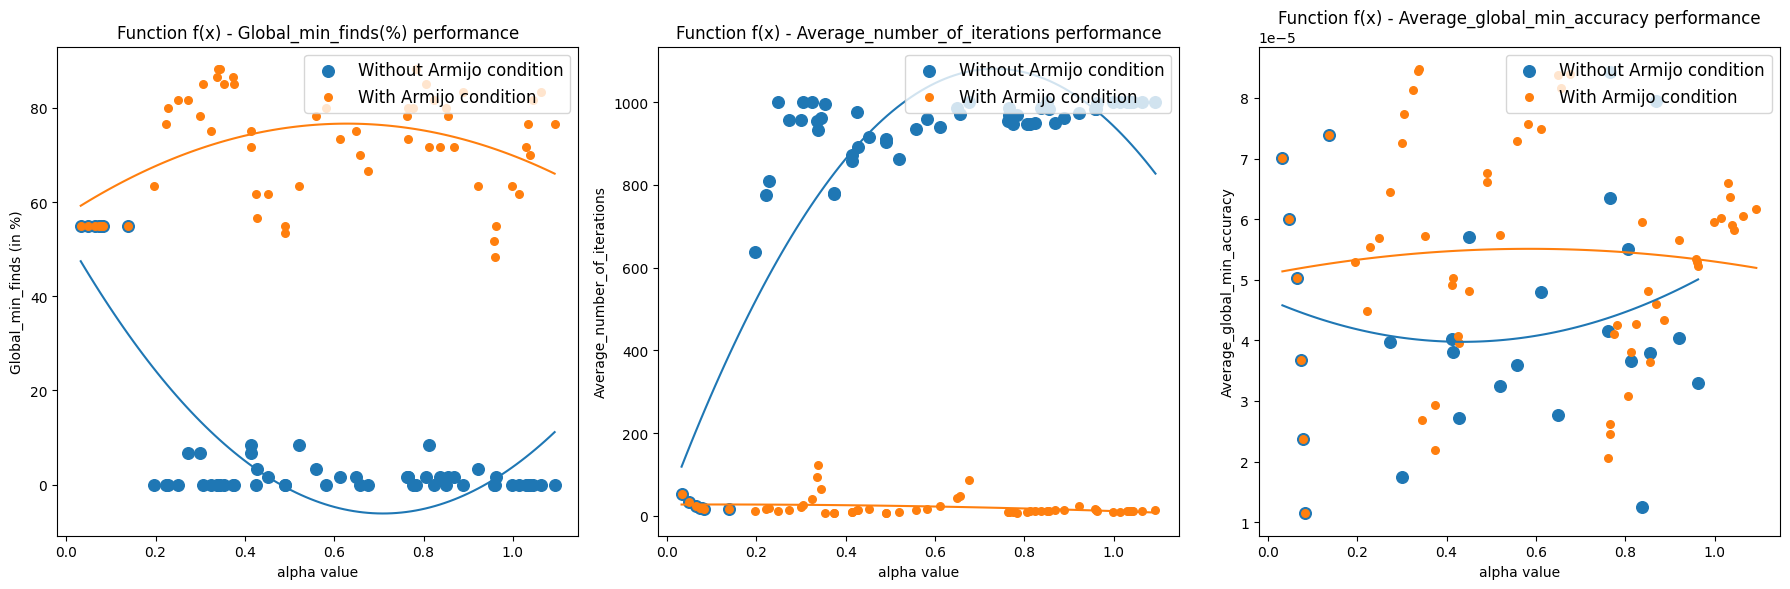

In [94]:
draw_perfomance_graph(dataframe_f, "f(x)")

***Analiza wykresów i plików pandas dla g(x_i)***

Funkcja g(x_i) jest funkcją z jednym ekstremum lokalnym/globalnym dlatego algorytm najszybszego spadku działa o wiele lepiej/szybciej. Znajduje minimum globalne praktycznie zawsze i szybko z dobrą dokładnością.

Wnioski z wykresów:
1. Wykres zależności wielkości współczynnika alpha do % znalezionych minimów globalnych:
    - Algorytm `lepiej` poradził sobie w przypadku `użycia warunku armijo` (znajdował glonalne minimum `zawsze`). Sama `wartość początkowa alpha nie ma znaczenia`. 
    
    - W przypadku `braku warunku armijo` algorytm radził sobie podobnie (tylko dla wartości powyżej `1` nie znajdował globalnego minimum bo algorytm się "wykrzaczał").


2. Wykres zależności wielkości współczynnik alpha do ilości iteracji algorytmu najszybszego spadku:
    - Algorytm `lepiej` poradził sobie w przypadku `użycia warunku armijo`. Działał bardzo szybko średnio w kilka iteracji. `Wartość początkowa alpha nie ma znaczenia`.
    
    - W przypadku `braku warunku armijo` algorytm radził sobie podobnie (tylko dla wartości powyżej `1` przekraczał 1000 iteracji bo algorytm się "wykrzaczał").


3. Wykres zależności wielkości współczynnik alpha do dokładności z jaką algorytm najszybszego spadku znalazł minimum:
    - W tym przypadku `warunek armijo nie ma większego znaczenia`. Algorytm jesli znajduje, to znajduje minimum z `porównywalną dokładnością`. Jednakże, algorytm bez warunku armijo ma tendencję do "wykrzaczania" algorytmu więc dla większych wartości alpha dokładność jest nieskończona (NaN) - algorytm nie wyznaczył minimum więc nie ma sensu mówić o dokładności. Dlatego jest mniej punktów niebieskich od punktów pomarańczowych.

In [95]:
dataframe_g = create_raw_dataframe(g, g_grad, min_g.x, "g(x_i)", 2, 60)
dataframe_g = create_performance_dataframe(dataframe_g, "g(x_i)")

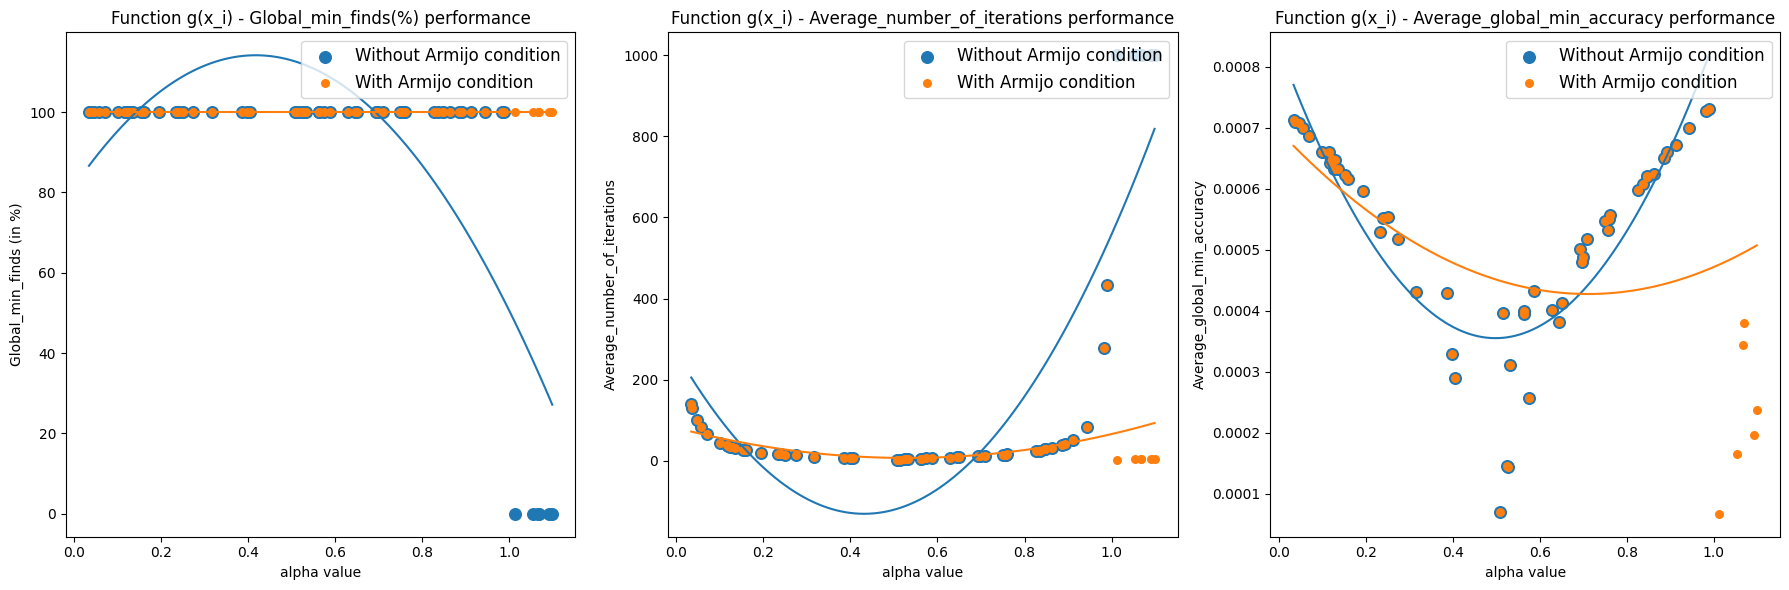

In [96]:
draw_perfomance_graph(dataframe_g, "g(x_i)")

# Testy

In [97]:
import ipytest
ipytest.autoconfig()

In [98]:
%%ipytest
def test_gradient_descent_2D():
    def h(x): return x*x
    def h_grad(x): return 2*x
    x0 = 10
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent(x0, h, h_grad, alpha, epsilon, max_iter, False)
    assert round(x) == 0

def test_gradient_descent_2D_armijo_on():
    def h(x): return x*x
    def h_grad(x): return 2*x
    x0 = 10
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent(x0, h, h_grad, alpha, epsilon, max_iter, True)
    assert round(x) == 0

def test_gradient_descent_2D_linear():
    def h(x): return 2*x
    def h_grad(x): return 2
    x0 = 10
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 1000
    x, i = gradient_descent(x0, h, h_grad, alpha, epsilon, max_iter, False)
    assert x == None
    assert i == max_iter

def test_gradient_descent_2D_func_with_two_mins_1():
    def h(x): return np.power(x, 4) - 2*np.power(x, 3) - np.power(x, 2) + 2*x
    def h_grad(x): return 4*np.power(x, 3) - 6*np.power(x, 2) - 2*x + 2
    x0 = 2
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent(x0, h, h_grad, alpha, epsilon, max_iter, False)
    assert round(x, 1) == 1.6

def test_gradient_descent_2D_func_with_two_mins_2():
    def h(x): return np.power(x, 4) - 2*np.power(x, 3) - np.power(x, 2) + 2*x
    def h_grad(x): return 4*np.power(x, 3) - 6*np.power(x, 2) - 2*x + 2
    x0 = -1
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent(x0, h, h_grad, alpha, epsilon, max_iter, False)
    assert round(x, 1) == -0.6

def test_gradient_desced_3D_func():
    def h(x_i): return  2*np.power(x_i[0], 2) + 5*np.power(x_i[1], 2)
    def h_grad(x_i): return np.array([4*x_i[0], 10*x_i[1]])
    x0 = [1, 1]
    alpha = 0.1
    epsilon = 0.0001
    max_iter = 100
    x, i = gradient_descent(x0, h, h_grad, alpha, epsilon, max_iter, False)
    assert round(x[0]) == 0
    assert round(x[1]) == 0

......                                                                                       [100%]
6 passed in 0.07s
